## Environment setup

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/seantyh/modist

Cloning into 'modist'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 99 (delta 38), reused 90 (delta 29), pack-reused 0
Unpacking objects: 100% (99/99), done.


In [4]:
!mkdir -p modist/data
!mount --bind -r /content/drive/Shareddrives/LOPE/國際合作/Redhen/modist/data modist/data

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [10]:
!ls modist/data

50_week_5008_lang.txt  c5008_list.txt  lang_map.csv  mp3_split.json  segments
abo16.tsv	       langfeats       mp3	     pcm


In [11]:
with open("modist/data/abo16.tsv", "r") as fin:
    abo16_map = {}
    for ln in fin.readlines()[1:]:
        toks = ln.strip().split("\t")
        if len(toks) < 2: continue
        abo16_map[toks[1]] = toks[0]
        if len(toks) >= 3:
            abo16_map[toks[2]] = toks[0]

In [12]:
# load dummy dataframe and transpose it
feat_dummy = pd.read_csv("modist/data/langfeats/formosan_dummies.csv").transpose()
feat_dummy.columns = feat_dummy.iloc[0, :]
feat_dummy.drop("Feature", axis=0, inplace=True)
feat_dummy.columns.names = [None]

# load lgs dataframe
feat_lgs = pd.read_csv("modist/data/langfeats/formosan_lgs.csv").set_index("Language")

# map language names with abo16
feat_dummy.index = [abo16_map.get(x, None) for x in feat_dummy.index.values]
feat_lgs.index = [abo16_map.get(x, None) for x in feat_lgs.index.values]

# remove duplicated features in lgs
dummy_feat_names = [x.lower() for x in feat_dummy.columns.values]
lgs_feat_names = [x for x in feat_lgs.columns.values]
lgs_intersection = [x for x in lgs_feat_names if x.lower() in dummy_feat_names]
feat_lgs = feat_lgs.drop(lgs_intersection, axis=1)
print("duplicated lgs features: ", lgs_intersection)

duplicated lgs features:  ['Voicelessretroflexplosive', 'Voicelesspalatalplosive']


In [13]:
print("feat_dummy languages: ", feat_dummy.index.values)
print("feat_lgs languages: ", feat_lgs.index.values)
lgs_phone_last_idx = np.where(feat_lgs.columns.values == "Definiteorspecificarticles")[0][0]
print(lgs_phone_last_idx)
feat_lgs_pfeats = feat_lgs.iloc[:, :lgs_phone_last_idx+1]

feat_dummy languages:  ['Amis' 'Atayal' 'Paiwan' 'Bunun' 'Pinuyumayan' 'Rukai' 'Cou' 'Saysiyat'
 'Yami' 'Thau' 'Kavalan' 'Truku' 'Sakizaya' 'Seediq' "Hla'alua"
 'Kanakanavu']
feat_lgs languages:  ['Atayal' 'Saysiyat' None 'Thau' 'Bunun' 'Seediq' 'Cou' 'Rukai' 'Paiwan'
 'Pinuyumayan' 'Amis' 'Kavalan' 'Yami']
59


In [14]:
# create a feature dataframe with phonetic features only
feat_phones = feat_dummy.merge(feat_lgs_pfeats, left_index=True, right_index=True)
feat_all = feat_dummy.merge(feat_lgs, left_index=True, right_index=True)

In [15]:
feat_phones

,voicedbilabialnasal,voicelessbilabialplosive,voicedbilabialplosive,voicedbilabialimplosive,voicelessbilabialnonsibilantfricative,voicedbilabialnonsibilantfricative,voicelesslabiodentalnonsibilantfricative,voicedlabiodentalnonsibilantfricative,voicelessdentalnonsibilantfricative,voiceddentalnonsibilantfricative,voicedalveolarnasal,voicelessalveolarplosive,voicedalveolarplosive,voicedalveolarimplosive,voicelessalveolarsibilantaffricate,voicelessalveolarsibilantfricative,voicedalveolarsibilantfricative,voicelessalveolarlateralfricative,voicedalveolarlateralfricative,voicedalveolarlateralapproximant,voicedalveolartrill,voicedalveolartaporflap,voicelesspostalveolarsibilantaffricate,voicedpostalveolarsibilantaffricate,voicelesspostalveolarsibilantfricative,voicedpostalveolarsibilantfricative,voicelessretroflexplosive,voicedretroflexplosive,voicelessretroflexsibilantfricative,voicedretroflexsibilantfricative,voicedretroflexapproximant,voicedretroflexlateralapproximant,voicelesspalatalplosive,voicedpalatalplosive,voicedpalatalapproximant,voicedpalatallateralapproximant,voicedvelarnasal,voicelessvelarplosive,voicedvelarplosive,voicelessvelarnonsibilantfricative,...,Alveolarvoicedretrofleximplosive,Palatalvoicedplosive,Velarvoicedplosive,Palatalaspiratedvoicelessaffricate,Palatalvoicedaffricate,Labialdentalvoicelessfricative,Interdentalvoicelessfricative,Alveolarvoicelessfricative,PalatalalveolarvoicelesssibilantFric,Velarvoicelessfricative,Uvularvoicelessfricative,GlottalVoicelessfricative,Bilabialvoicedfricative,Labialdentalvoicedfricative,Interdentalvoicedfricative,Alveolarvoicedfricative,Velarvoicedfricative,Uvularvoicedfricative,BilabialNasal,Alveolarnasal,Velarnasal,Alveolarvoicelesslateralfricative,Alveolarvoicedlateralapproximant,Retroflexvoicedlateralapproximant,Palatallateralapproximant,Alveolartrill,Alveolartap,Bilabialvelarvoicedapproximant,Palatalapproximant,Prenasalizedstops,Phonemicdistinctionbetweenlandr,Phonemicvelarfricativeorglide,Phonemicvoicingcontrastamongstops,Phonemicconsonantlength,Phonemicvowellength,Contrastivephonationtypesforvowels,Phonemicstress,Wordfinalconsonants,Consonantclusters,Definiteorspecificarticles
Amis,1,1,1,0,0,0,1,1,0,1,1,1,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,...,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,1,1,0,1,1,0,0,0,0,0,1,1,1
Atayal,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,1,1,1,0,1,0,0,1,0,1,1,0,1,1,0,0,0,0,0,1,1,1
Paiwan,1,1,1,0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,1,1,1,1,1,1,0,...,1,1,1,0,0,0,0,1,0,0,0,1,1,1,0,1,0,0,1,1,1,0,1,1,0,1,0,1,1,0,1,0,1,0,0,0,0,1,1,1
Bunun,1,1,0,1,0,0,0,1,0,1,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,1
Pinuyumayan,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,1,1,0,...,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1
Rukai,1,1,1,0,0,0,0,1,1,1,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1,0,...,1,0,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,1
Cou,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,...,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
Saysiyat,1,1,0,0,0,1,0,0,1,1,1,1,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1
Yami,1,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,1,0,1,1,1,0,...,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,1,1
Thau,1,1,1,0,1,1,0,0,1,1,1,1,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,1,1,1,1,0,0,1,0,0,1,0,0,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,1


In [18]:
lang_dist = pdist(np.array(feat_phones), metric='cityblock')

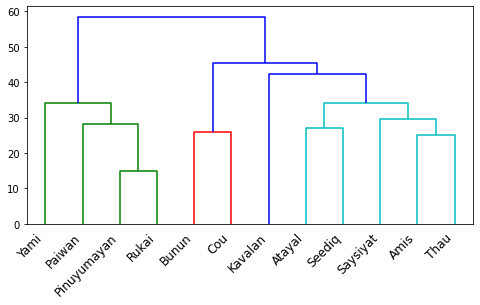

In [19]:
Z = linkage(lang_dist, 'ward')
plt.figure(figsize=(8,4))
dendrogram(Z, labels=feat_phones.index.values, leaf_rotation=45)
xlabels = plt.gca().get_xticklabels()
_ = plt.gca().set_xticklabels(xlabels, ha='right')

In [20]:
diff_cols = (feat_phones.loc["Pinuyumayan", :] != feat_phones.loc["Rukai", :])
diff_df = feat_phones.loc[["Pinuyumayan", "Rukai"], diff_cols].transpose()
print("different features: ", diff_df.shape[0])
diff_df

different features:  15


,Pinuyumayan,Rukai
voicedlabiodentalnonsibilantfricative,0,1
voicelessdentalnonsibilantfricative,0,1
voiceddentalnonsibilantfricative,0,1
voicelessalveolarsibilantaffricate,0,1
voicelessretroflexplosive,1,0
voicelessglottalplosive,1,0
Unaspiratedvoicelessuvularplosive,1,0
Palatalaspiratedvoicelessaffricate,0,1
Interdentalvoicelessfricative,0,1
GlottalVoicelessfricative,1,0


In [21]:
feat_phones.columns.values

array(['voicedbilabialnasal', 'voicelessbilabialplosive',
       'voicedbilabialplosive', 'voicedbilabialimplosive',
       'voicelessbilabialnonsibilantfricative',
       'voicedbilabialnonsibilantfricative',
       'voicelesslabiodentalnonsibilantfricative',
       'voicedlabiodentalnonsibilantfricative',
       'voicelessdentalnonsibilantfricative',
       'voiceddentalnonsibilantfricative', 'voicedalveolarnasal',
       'voicelessalveolarplosive', 'voicedalveolarplosive',
       'voicedalveolarimplosive', 'voicelessalveolarsibilantaffricate',
       'voicelessalveolarsibilantfricative',
       'voicedalveolarsibilantfricative',
       'voicelessalveolarlateralfricative',
       'voicedalveolarlateralfricative',
       'voicedalveolarlateralapproximant', 'voicedalveolartrill',
       'voicedalveolartaporflap',
       'voicelesspostalveolarsibilantaffricate',
       'voicedpostalveolarsibilantaffricate',
       'voicelesspostalveolarsibilantfricative',
       'voicedpostalveolarsibil